In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from ModelTrainer import RegressionModelTrainer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_csv("./data/Question4.csv")
data = data.drop(columns=['id'])

In [4]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [6]:
nan_counts = data.isna().sum()

In [7]:
data = data.dropna()

In [8]:
correlation_matrix = data.select_dtypes(exclude=["object"]).corr()

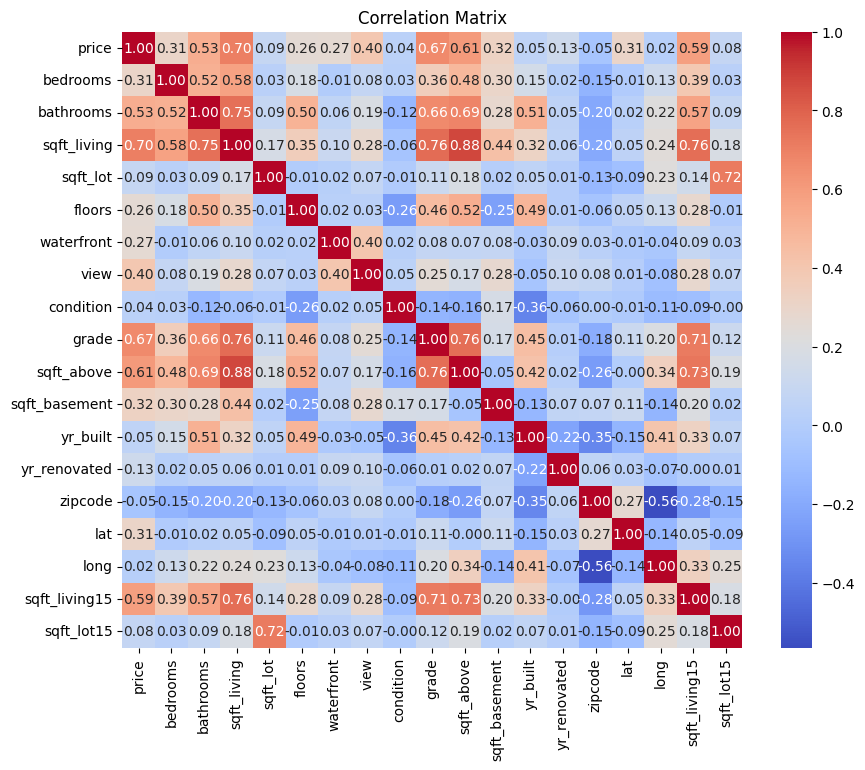

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [10]:
price_correlations = correlation_matrix["price"].sort_values(ascending=False)
print("The top features with the most correlation with Price:")
print(price_correlations[1:4])

The top features with the most correlation with Price:
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
Name: price, dtype: float64


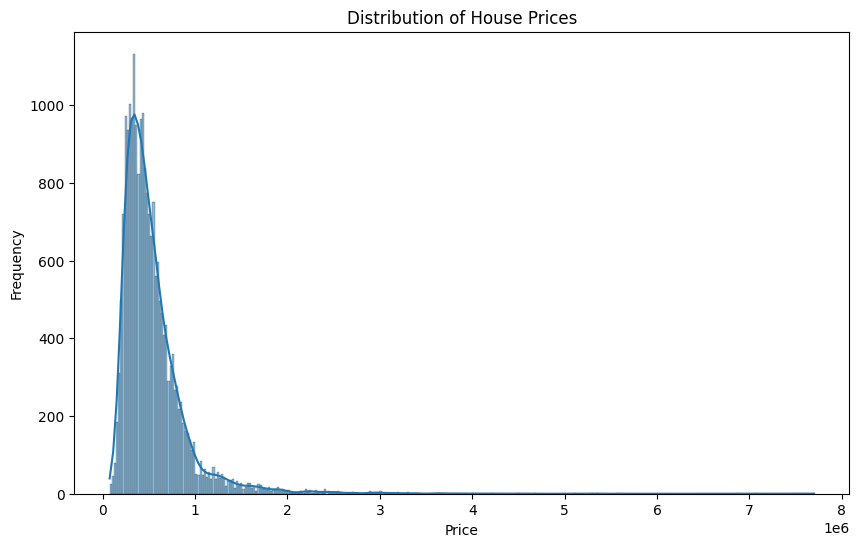

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

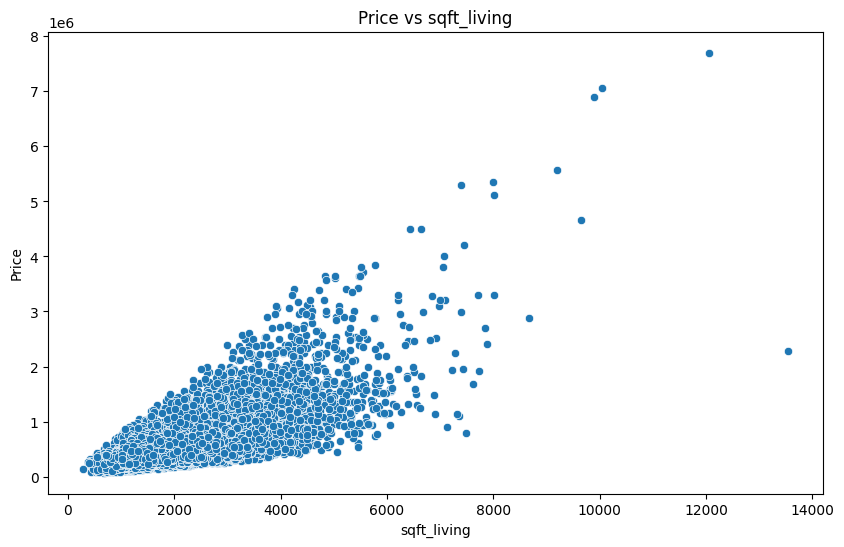

In [12]:
for i in range(1,2):
    top_feature = price_correlations.index[i] 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[top_feature], y=data['price'])
    plt.title(f"Price vs {top_feature}")
    plt.xlabel(top_feature)
    plt.ylabel("Price")
    plt.show()

In [13]:
data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y%m%dT%H%M%S')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.drop(columns=['date'])
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,2
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,...,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,6
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,...,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,1


In [14]:
X = data.drop('price', axis=1)
Y = data['price']
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.25, random_state=13)

In [15]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_validation_scaled = scaler.transform(X_validation) 
y_train_df = pd.DataFrame(y_train, columns=['price']) 
y_validation_df = pd.DataFrame(y_validation, columns=['price'])

In [16]:
class HousePriceMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(HousePriceMLP, self).__init__()
        layers = []
        previous_size = input_size
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            previous_size = hidden_size
        layers.append(nn.Linear(previous_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [17]:
X_train = torch.tensor(X_train_scaled, dtype=torch.float32) 
X_validation = torch.tensor(X_validation_scaled, dtype=torch.float32) 
y_train = torch.tensor(y_train_df.values, dtype=torch.float32).view(-1, 1)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_validation, y_validation)

In [18]:
def hyperparameter_tuning(train_dataset, test_dataset, input_size, learning_rates, hidden_layer_configs, lambdas):
    results = []
    for learning_rate in learning_rates:
        for hidden_layer_config in hidden_layer_configs:
            for lam in lambdas:
                model = HousePriceMLP(input_size, hidden_layer_config).to(device)
                model_trainer = RegressionModelTrainer(
                    model=model,
                    train_dataset=train_dataset,
                    test_dataset=test_dataset,
                    device=device,
                    learning_rate=learning_rate,
                    num_epochs=40
                )
                optimizer = optim.Adam(model_trainer.model.parameters(), lr=learning_rate, weight_decay=lam)
                _, _ = model_trainer.train_with_optimizer(optimizer)
                
                mae, rmse, _ = model_trainer.evaluate()
                results.append({
                    'learning_rate': learning_rate,
                    'hidden_layers': hidden_layer_config,
                    'lambda': lam,
                    'MAE': mae,
                    'RMSE': rmse
                })
                print(f"Learning Rate: {learning_rate}, Hidden Layers: {hidden_layer_config}, Lambda: {lam}")
    
    results_df = pd.DataFrame(results)
    return results_df

In [19]:
learning_rates = [0.01, 0.05]
lambdas = [1e-4, 1e-3]
hidden_layer_configs = [[64], [128], [256]]

In [20]:
# results_df = hyperparameter_tuning(train_dataset, test_dataset, input_size=X_train.shape[1],
                                    # learning_rates=learning_rates, hidden_layer_configs=hidden_layer_configs, lambdas=lambdas)

In [21]:
# print(results_df)

In [22]:
hidden_layer_config = [256]
learning_rate = 0.05
lam = 0.0001

Epoch [1/150], Train Loss: 226025271611.6212, Train MAE: 324569.6562, Validation Loss: 106251107424.2605, Validation MAE: 198533.3594
Epoch [2/150], Train Loss: 93812474957.2628, Train MAE: 193988.1719, Validation Loss: 94340143921.0777, Validation MAE: 191866.0469
Epoch [3/150], Train Loss: 82954925707.1425, Train MAE: 181182.7500, Validation Loss: 81885581627.3101, Validation MAE: 174892.0156
Epoch [4/150], Train Loss: 71480417018.0774, Train MAE: 165244.0312, Validation Loss: 69399910971.4996, Validation MAE: 161856.6875
Epoch [5/150], Train Loss: 61362888296.1436, Train MAE: 149222.8594, Validation Loss: 59617113770.9193, Validation MAE: 144894.2500
Epoch [6/150], Train Loss: 54131908692.8437, Train MAE: 137374.1562, Validation Loss: 53560980920.3731, Validation MAE: 139802.1406
Epoch [7/150], Train Loss: 49873222293.6926, Train MAE: 131737.6406, Validation Loss: 49833842171.0733, Validation MAE: 132431.5938
Epoch [8/150], Train Loss: 47390488056.5770, Train MAE: 129185.2578, Valid

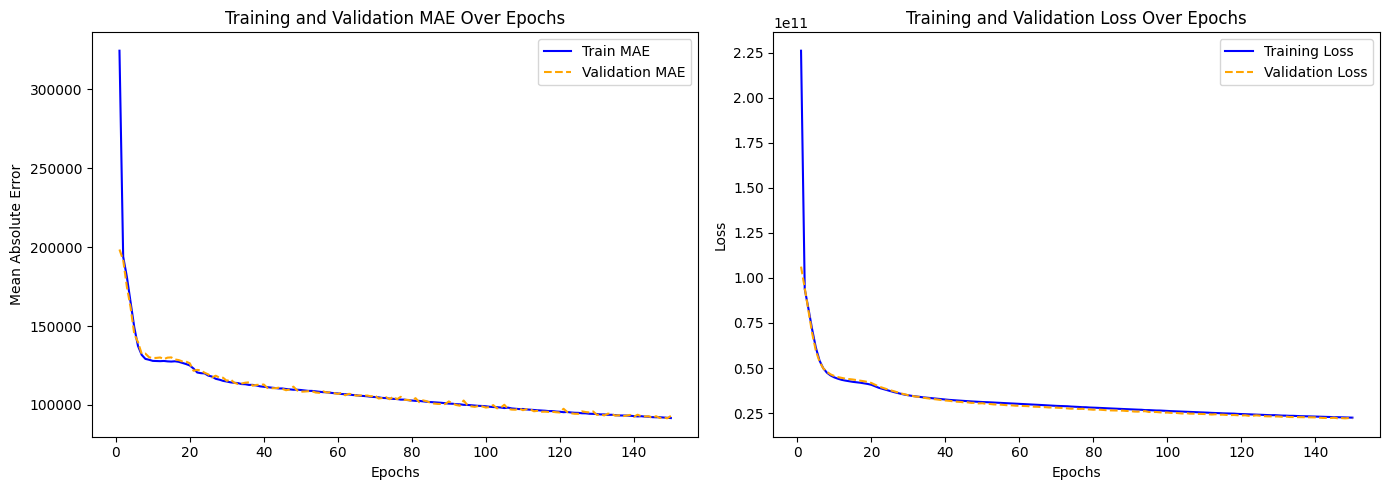

MAE: 93017.4062, RMSE: 148626.4375



In [23]:
model = HousePriceMLP(X_train.shape[1], hidden_layer_config).to(device)
model_trainer = RegressionModelTrainer(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    learning_rate=learning_rate,
    num_epochs=150
)
optimizer = optim.Adam(model_trainer.model.parameters(), lr=learning_rate, weight_decay=lam)
train_losses, val_losses = model_trainer.train_with_optimizer(optimizer)
                
model_trainer.plot_metrics()
mae, rmse, _ = model_trainer.evaluate()
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}\n")

In [24]:
learning_rates = [0.01, 0.05]
lambdas = [1e-4, 1e-3]
hidden_layer_configs = [[64,128], [128,256]]

In [25]:
# results_df = hyperparameter_tuning(train_dataset, test_dataset, input_size=X_train.shape[1],
#                                     learning_rates=learning_rates, hidden_layer_configs=hidden_layer_configs, lambdas=lambdas)

In [26]:
# print(results_df)

In [27]:
hidden_layer_config = [64, 128]
learning_rate = 0.05
lam = 0.0010

Epoch [1/150], Train Loss: 93433415652.5822, Train MAE: 187266.1875, Validation Loss: 47550435761.5514, Validation MAE: 133669.6406
Epoch [2/150], Train Loss: 41666009591.5030, Train MAE: 125322.5859, Validation Loss: 38001393451.7720, Validation MAE: 119787.3672
Epoch [3/150], Train Loss: 36305235487.2399, Train MAE: 118228.5234, Validation Loss: 33242581971.2805, Validation MAE: 115827.9688
Epoch [4/150], Train Loss: 34328591307.1227, Train MAE: 115810.3984, Validation Loss: 35230752589.1221, Validation MAE: 113247.9531
Epoch [5/150], Train Loss: 32331014012.1542, Train MAE: 111861.2266, Validation Loss: 30514510383.3723, Validation MAE: 110727.0312
Epoch [6/150], Train Loss: 31790831478.3106, Train MAE: 111385.0938, Validation Loss: 29581117899.3220, Validation MAE: 112532.2734
Epoch [7/150], Train Loss: 30759892059.9193, Train MAE: 109431.3516, Validation Loss: 30148122965.0807, Validation MAE: 115140.9375
Epoch [8/150], Train Loss: 30200342097.2112, Train MAE: 108504.8516, Validat

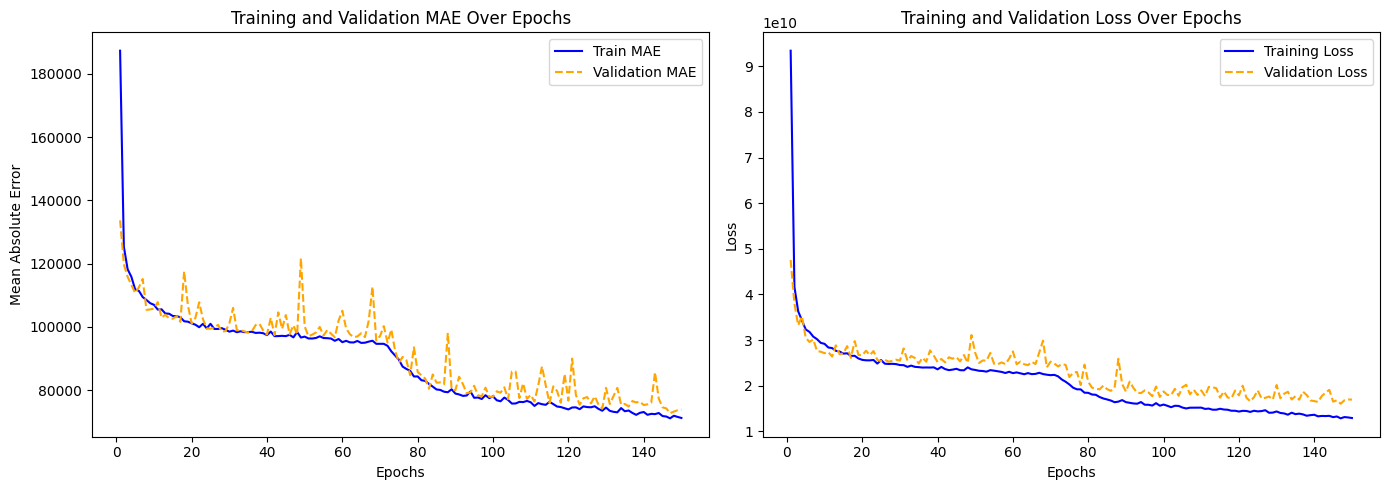

MAE: 73827.1875, RMSE: 130230.2969



In [29]:
model = HousePriceMLP(X_train.shape[1], hidden_layer_config).to(device)
model_trainer = RegressionModelTrainer(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    learning_rate=learning_rate,
    num_epochs=150
)
optimizer = optim.Adam(model_trainer.model.parameters(), lr=learning_rate, weight_decay=lam)
train_losses, val_losses = model_trainer.train_with_optimizer(optimizer)
                
model_trainer.plot_metrics()
mae, rmse, _ = model_trainer.evaluate()
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}\n")

In [ ]:
num_samples = 5
random_indices = torch.randperm(X_validation.size(0))[:num_samples]
X_validation_samples = X_validation[random_indices]
y_validation_samples = y_validation[random_indices]

X_validation_samples = X_validation_samples.to(device)
y_validation_samples = y_validation_samples.to(device)

model.eval()
with torch.no_grad():
    preds = model(X_validation_samples)

for i in range(num_samples):
    print(f'For sample {i+1}: Prediction = {preds[i].item()}, Actual = {y_validation_samples[i].item()}')

For sample 1: Prediction = 282701.21875, Actual = 267000.0
For sample 2: Prediction = 471731.09375, Actual = 500000.0
For sample 3: Prediction = 872726.75, Actual = 1070000.0
For sample 4: Prediction = 719335.625, Actual = 725000.0
For sample 5: Prediction = 570099.125, Actual = 495000.0
